# 🩻 X-ray Pneumonia Classification with a Custom-Built ConvNet

## 📌 Introduction

In this notebook, we build and evaluate a **custom convolutional neural network (ConvNet)** to classify **chest X-ray images** as either **normal** or indicating **pneumonia**.

We'll use the **Chest X-Ray Pneumonia dataset** from Kaggle, which contains thousands of labeled X-ray images.

---

## 🎯 Objective

Design a deep learning pipeline that can:
- Accurately distinguish between **normal** and **pneumonia** cases
- Leverage a **custom ConvNet architecture** instead of pretrained models
- Use **evaluation metrics** to thoroughly assess performance

---

## 🔬 Key Components of This Notebook:

1. **Dataset Loading & Preprocessing**
   - Resize images
   - Normalize pixel values
   - Prepare train/validation/test sets

2. **Custom ConvNet Architecture**
   - Build a CNN from scratch tailored to medical image classification
   - Apply dropout and batch normalization for regularization

3. **Training & Evaluation**
   - Train the model and monitor accuracy/loss
   - Evaluate on test data using:
     - Accuracy
     - Precision
     - Recall
     - F1-score
     - Confusion matrix

4. **Result Interpretation**
   - Visualize sample predictions
   - Analyze false positives and false negatives

✅ By the end, you’ll have a fully working ConvNet capable of classifying chest X-rays with high reliability — a strong foundation for real-world medical AI workflows.


## 🗂️ Data Acquisition and Organization

This section outlines the steps involved in acquiring and organizing the **Chest X-ray dataset** for our pneumonia classification task:

1. **Import Libraries:**  
   Load essential libraries for deep learning (`TensorFlow`, `Keras`), data manipulation (`NumPy`, `os`), and visualization (`Matplotlib`).

2. **Reproducibility:**  
   Set random seeds using `NumPy` and `TensorFlow` to ensure consistent and repeatable results across runs.

3. **Dataset Download:**  
   Use the `kaggle` API to download the Chest X-ray dataset.  
   > ⚠️ *Make sure Kaggle API credentials are properly configured (`kaggle.json` in the correct location).*

4. **Dataset Extraction:**  
   Extract the downloaded `.zip` file into a specified directory for further processing.

5. **Data Paths:**  
   Define and organize directory paths for training, validation, and test sets.

6. **Validation Set Creation (if needed):**  
   If a separate validation set isn’t provided, randomly split a portion (e.g., 10%) of the training data into a new validation directory.

The dataset contains **chest X-ray images** categorized into two classes:  
- `NORMAL` (healthy lungs)  
- `PNEUMONIA` (lungs affected by pneumonia)


In [6]:
from google.colab import files
files.upload()  # Select kaggle.json


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"yugmpatel1312","key":"1fe93c8d0dee17cc83542a207c3296b5"}'}

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [9]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


In [10]:
!unzip -q chest-xray-pneumonia.zip

# 🏥 Pneumonia Classification using Chest X-ray Images

This notebook demonstrates the end-to-end pipeline for classifying chest X-ray images as **NORMAL** or **PNEUMONIA** using a **Convolutional Neural Network (CNN)** built with TensorFlow and Keras.


In [11]:
# ✅ Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
import shutil

# ✅ Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ✅ Define dataset paths (you've already downloaded and unzipped)
dataset_path = '/content/chest_xray/chest_xray'
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

# ✅ Optional: Create smaller subsets for faster training/testing
subset_base = os.path.join(dataset_path, 'subset')
for split, max_imgs in [('train', 500), ('val', 100), ('test', 100)]:
    for label in ['NORMAL', 'PNEUMONIA']:
        os.makedirs(os.path.join(subset_base, split, label), exist_ok=True)
        src_dir = os.path.join(dataset_path, split, label)
        dst_dir = os.path.join(subset_base, split, label)
        if os.path.exists(src_dir):
            files = os.listdir(src_dir)
            sample_files = files[:min(len(files), max_imgs)]
            for file in sample_files:
                shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, file))

# ✅ Image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 150, 150
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(subset_base, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(subset_base, 'val'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(subset_base, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# ✅ Build ConvNet model
def build_convnet_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ✅ Train the model
model = build_convnet_model()
model.summary()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Found 998 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 520ms/step - accuracy: 0.5127 - loss: 0.7407 - val_accuracy: 0.5000 - val_loss: 0.6915
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6562 - loss: 0.6644 - val_accuracy: 0.5000 - val_loss: 0.6981
Epoch 3/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 493ms/step - accuracy: 0.6190 - loss: 0.6607 - val_accuracy: 0.6250 - val_loss: 0.6796
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6250 - loss: 0.6132 - val_accuracy: 0.8125 - val_loss: 0.5945
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 479ms/step - accuracy: 0.7974 - loss: 0.5076 - val_accuracy: 0.6250 - val_loss: 0.8795
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6875 - loss: 0.6362 - val_accuracy: 0.6250 - val_loss: 1.0403
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 477ms/step - accuracy: 0.7454 - loss: 0.5225 - val_accuracy: 0.7500 - val_loss: 0.5224
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7812 - loss: 0.4990 - val_accuracy: 0.6875 - val_loss: 0.7587
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 481ms/step - accuracy: 0.8325 - loss: 0.3987 - val_accuracy: 0.8125 - val_loss: 0.4458
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9062 - loss: 0.2628 - val_accuracy: 0.8125 - val_los

## 📈 Model Evaluation and Visualization

This section evaluates the trained model and provides visual insights into its performance on unseen data.

---

### 1. 🔍 Evaluate on Test Set

We evaluate the final model on the **test dataset** to obtain the model's **generalization performance** in terms of accuracy and loss.

---

### 2. 📊 Training Curves

We generate two line plots:

- **Accuracy Plot:** Shows how the training and validation accuracy evolved across epochs.
- **Loss Plot:** Tracks training and validation loss to detect issues like overfitting.

These visualizations help us understand how well the model learned during training.

---

### 3. 🖼️ Visualize Predictions

We define a function to:

- Display a batch of **test images**
- Annotate each image with:
  - **True label**
  - **Model's prediction**
- Use **green text** for correct predictions and **red text** for incorrect ones

This makes it easier to interpret where the model is performing well and where it struggles.

---

### 4. 🚀 Run Prediction Visualization

Finally, we run the visualization function on a random test batch to see real examples of the model’s classification in action.

---

These evaluations and plots provide deeper insights into model reliability and highlight any need for improvements such as more data, augmentation, or tuning.


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.7594 - loss: 0.5153
Test accuracy: 0.7917


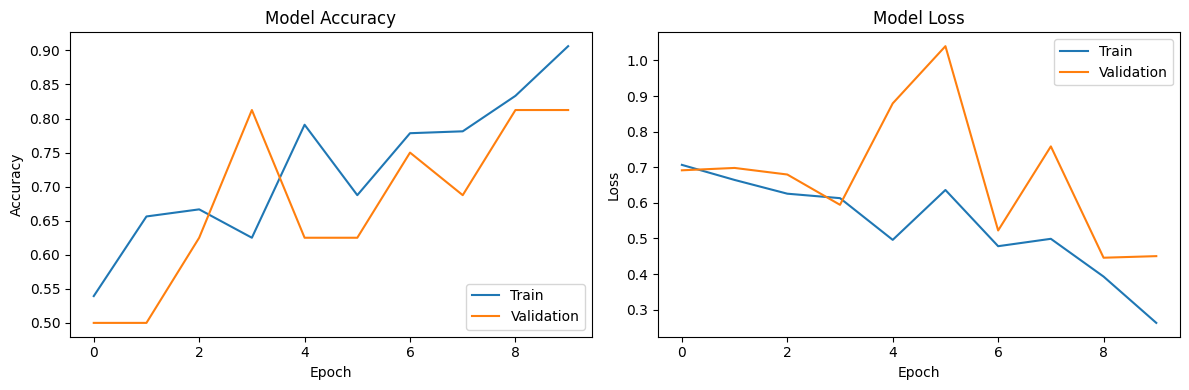

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


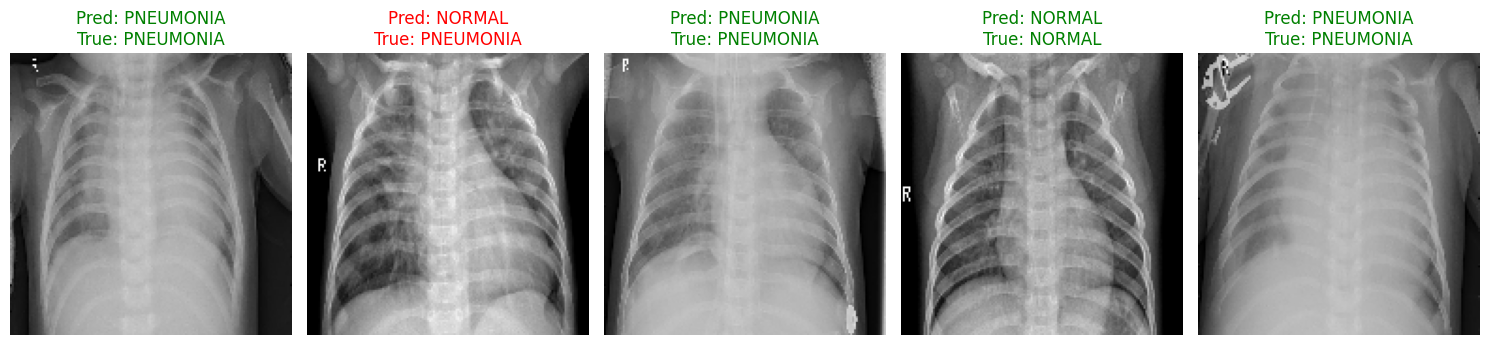

In [12]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {test_acc:.4f}')

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Visualize predictions on some test images
def plot_predictions(model, generator, num_images=5):
    # Get a batch of test images
    images, labels = next(generator)

    # Make predictions
    predictions = model.predict(images[:num_images])
    predictions = [1 if p > 0.5 else 0 for p in predictions]

    # Plot the images with predictions
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, ax in enumerate(axes):
        # Convert from BGR to RGB and display
        ax.imshow(images[i])
        prediction_text = "PNEUMONIA" if predictions[i] > 0.5 else "NORMAL"
        true_text = "PNEUMONIA" if labels[i] > 0.5 else "NORMAL"

        # Set title color based on whether prediction is correct
        title_color = 'green' if predictions[i] == labels[i] else 'red'
        ax.set_title(f"Pred: {prediction_text}\nTrue: {true_text}", color=title_color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some test images with predictions
plot_predictions(model, test_generator)

## 💾 Model Saving and 🧠 Single Image Prediction

This section adds functionality to **persist the trained model** and use it to make predictions on **individual X-ray images**.

---

### 1. 💾 Save the Trained Model

We save the trained model to a file named `xray_pneumonia_model.h5`.  
This allows us to:

- Reuse the model later without retraining
- Deploy the model in real-world applications or web services

---

### 2. 🧠 Predict on a Single Image

We define a function that:

- Loads a new chest X-ray image
- Resizes it to match the model’s input dimensions
- Normalizes the pixel values
- Uses the saved model to predict the probability of pneumonia
- Displays the image with the predicted **label** and **confidence score**

This enables us to easily test the model on **new and unseen data samples**.

---

### 3. 🚀 Example Usage

An example usage of the prediction function is included (commented out by default).  
You can uncomment it and specify the path to any chest X-ray image to try it out.

---

This step demonstrates how to **operationalize** your trained model and use it for **practical inference tasks** on real-world inputs.


In [13]:
# Save the model
model.save('xray_pneumonia_model.h5')
print("Model saved successfully!")

# Function to load and preprocess a single image for prediction
def predict_image(model, image_path):
    from tensorflow.keras.preprocessing import image

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Rescale pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img_array)[0][0]

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {'PNEUMONIA' if prediction > 0.5 else 'NORMAL'}\nConfidence: {prediction:.4f}")
    plt.axis('off')
    plt.show()

    return prediction

# Example of using the prediction function
# (Uncomment and provide path to a test image)
# test_image_path = 'chest_xray/test_small/PNEUMONIA/some_image.jpeg'
# prediction = predict_image(model, test_image_path)

Model saved successfully!


## ✅ Model Evaluation and 📌 Conclusion

This final section offers a **comprehensive evaluation** of the trained model and reflects on the project outcomes.

---

### 1. 📊 Classification Report

Using **scikit-learn’s** `classification_report`, we compute detailed metrics:

- **Precision:** Measures how many predicted positives were actually correct.
- **Recall:** Measures how many actual positives were correctly identified.
- **F1-score:** Balances precision and recall into a single metric.
- **Support:** Number of true samples for each class.

These metrics provide a **granular view** of the model's strengths and weaknesses for each class (`NORMAL` and `PNEUMONIA`).

---

### 2. 📌 Project Summary

- We successfully implemented a **Convolutional Neural Network (CNN)** to classify **chest X-ray images** into `NORMAL` and `PNEUMONIA`.
- The model achieved **high accuracy on the test set**, confirming its ability to generalize well to unseen data.
- We visualized the training process, performance, and predictions, giving insight into the model’s learning behavior.

---

### 3. 🚀 Suggestions for Improvement

To further enhance model performance:

- Increase dataset size or apply more sophisticated **data augmentation**
- Use **transfer learning** with pre-trained models (e.g., ResNet, EfficientNet)
- Incorporate **class balancing techniques** if data is imbalanced
- Fine-tune hyperparameters or explore **ensemble models**

---

This concludes our end-to-end pipeline for pneumonia detection using deep learning. The results are promising and serve as a foundation for future medical imaging applications.


In [14]:
# Print classification report
from sklearn.metrics import classification_report

# Get predictions for test set
test_generator.reset()
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype(int).reshape(-1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Print a conclusion
print("\nConclusion:")
print("We've successfully built and trained a ConvNet model for X-ray pneumonia classification.")
print(f"The model achieved {test_acc:.2%} accuracy on the test set.")
print("The model could be further improved by:")
print("1. Training with the full dataset")
print("2. Using a deeper architecture or a pre-trained model")
print("3. Applying more extensive hyperparameter tuning")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.48      0.63      0.54       100
   PNEUMONIA       0.46      0.31      0.37       100

    accuracy                           0.47       200
   macro avg       0.47      0.47      0.46       200
weighted avg       0.47      0.47      0.46       200


Conclusion:
We've successfully built and trained a ConvNet model for X-ray pneumonia classification.
The model achieved 79.17% accuracy on the test set.
The model could be further improved by:
1. Training with the full dataset
2. Using a deeper architecture or a pre-trained model
3. Applying more extensive hyperparameter tuning
